In [1]:
import importlib

import braidz_analysis

importlib.reload(braidz_analysis)
import matplotlib.pyplot as plt
import numpy as np

from braidz_analysis import braidz, processing

2024-12-16 12:02:24,212 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [2]:
root_folder = "/home/buchsbaum/mnt/nfc3008/md0/Experiments"
exp_list = [
    "20241213_143459.braidz",
]

combined_data = braidz.read_multiple_braidz(
    exp_list, root_folder=root_folder, parser="pyarrow"
)

2024-12-16 12:02:24,299 [INFO] Processing 1 files
2024-12-16 12:02:24,453 [INFO] Reading /home/buchsbaum/mnt/nfc3008/md0/Experiments/20241213_143459.braidz using pyarrow


Processing file 1/1: /home/buchsbaum/mnt/nfc3008/md0/Experiments/20241213_143459.braidz


2024-12-16 12:02:59,008 [WARNING] PyArrow parsing failed: Empty CSV file:<zipfile.ZipExtFile name='experiment_info.csv' mode='r'>, falling back to pandas
2024-12-16 12:02:59,009 [WARNING] Empty CSV file <zipfile.ZipExtFile name='experiment_info.csv' mode='r'> encountered
2024-12-16 12:02:59,908 [INFO] Combining processed data
2024-12-16 12:02:59,909 [INFO] Combined 1 kalman estimate dataframes
2024-12-16 12:02:59,910 [INFO] Combined 1 stimulus dataframes
2024-12-16 12:02:59,910 [INFO] Combined 1 optogenetics dataframes


In [3]:
data = processing.get_stim_or_opto_data(combined_data["df"], combined_data["opto"])

100%|██████████| 286/286 [00:02<00:00, 102.93it/s]


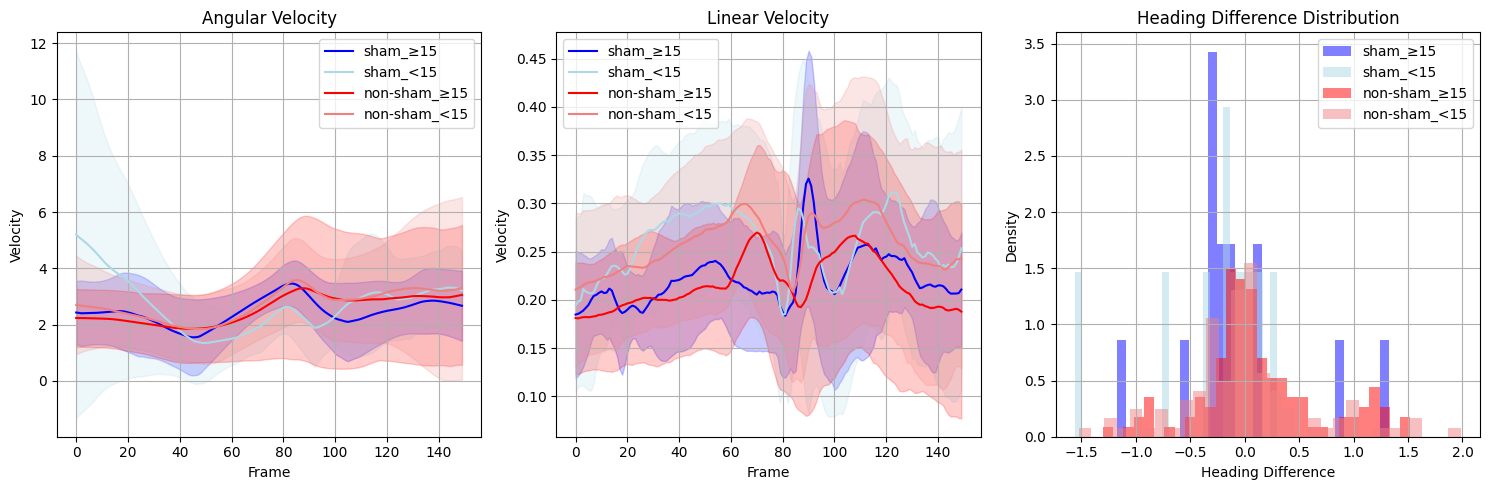

In [4]:
# Split data into groups based on sham status and frames in opto radius
def split_data_into_groups(data):
    groups = {}
    conditions = [
        ("sham", True, "≥15", lambda x: x >= 15),
        ("sham", True, "<15", lambda x: x < 15),
        ("non-sham", False, "≥15", lambda x: x >= 15),
        ("non-sham", False, "<15", lambda x: x < 15),
    ]

    for sham_label, is_sham, radius_label, radius_condition in conditions:
        mask = (data["sham"] == is_sham) & radius_condition(
            data["frames_in_opto_radius"]
        )
        groups[f"{sham_label}_{radius_label}"] = {
            "angular_velocity": np.abs(data["angular_velocity"])[mask],
            "linear_velocity": data["linear_velocity"][mask],
            "heading_diff": data["heading_diff"][mask],
        }

    return groups


# Plot settings
colors = {
    "sham_≥15": "blue",
    "sham_<15": "lightblue",
    "non-sham_≥15": "red",
    "non-sham_<15": "lightcoral",
}

# Split the data
groups = split_data_into_groups(data)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
# Plotting for angular and linear velocities
for ax_idx, metric in enumerate(["angular_velocity", "linear_velocity"]):
    for group_name, group_data in groups.items():
        if len(group_data[metric]) > 0:  # Check if group has data
            mean_trace = np.mean(group_data[metric], axis=0)
            std_trace = np.std(group_data[metric], axis=0)

            x = np.arange(len(mean_trace))
            axs[ax_idx].plot(x, mean_trace, label=group_name, color=colors[group_name])
            axs[ax_idx].fill_between(
                x,
                mean_trace - std_trace,
                mean_trace + std_trace,
                alpha=0.2,
                color=colors[group_name],
            )

    axs[ax_idx].set_title(f'{metric.replace("_", " ").title()}')
    axs[ax_idx].set_xlabel("Frame")
    axs[ax_idx].set_ylabel("Velocity")
    axs[ax_idx].legend()
    axs[ax_idx].grid(True)

# Plotting heading difference histogram
for group_name, group_data in groups.items():
    if len(group_data["heading_diff"]) > 0:  # Check if group has data
        axs[2].hist(
            group_data["heading_diff"],
            bins=30,
            alpha=0.5,
            label=group_name,
            color=colors[group_name],
            density=True,
        )

axs[2].set_title("Heading Difference Distribution")
axs[2].set_xlabel("Heading Difference")
axs[2].set_ylabel("Density")
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Understanding the Data Structure

The `combined_data` dictionary contains structured data from braidz files with several key components:

## Key Components
- `df`: Contains the main `kalman_estimates` data (always present)
- `stim`: Contains stimulus-related data (if present)
- `opto`: Contains optogenetics data (if present)

Example of checking available keys:
```
print(f"Available data keys: {list(combined_data.keys())}")
```

## Data Structure
The main DataFrame (`combined_data['df']`) contains various measurements and tracking data. You can examine its structure:

```
# View all columns in the main DataFrame
columns = combined_data['df'].columns
print("Available columns:", columns.tolist())
```

## Working with Groups

The data is organized hierarchically using two main identifiers:
- `obj_id`: Unique identifier for each tracked object (can be the same across different experiments)
- `exp_num`: Experiment number for different recording sessions

### Grouping Patterns

1. Group by object:
```
object_groups = combined_data['df'].groupby('obj_id')
```

2. Group by experiment:
```
experiment_groups = combined_data['df'].groupby('exp_num')
```

3. Group by both (most common use case):
```
# This creates groups for each unique object within each experiment
obj_exp_groups = combined_data['df'].groupby(['obj_id', 'exp_num'])
```